# Private Set Intersection in Julia

Brian Thorne, [@thorneynz](https://twitter.com/thorneynz)

Let's make a Julia implementation of private set intersection! Our template will be the 2004 paper _Efficient Private Matching and Set Intersection_ by Michael Freedman, Kobbi Nissim, and Benny Pinkas. This will serve as the first example use of my [Paillier.jl](https://github.com/hardbyte/Paillier.jl/) package (Paillier is a partially homomorphic cryptosystem).

_Note quotes from the paper will appear like this:_

> We consider the problem of computing the intersection of private datasets of two parties, where the datasets contain lists of elements taken from a large domain. This problem has many applications for online collaboration.

The point is that computing set intersection in a privacy preserving way is a highly useful thing to do. The *Confidential Computing* team at CSIRO's Data61 along with our spin-out tracked company [N1 Analytics](https://n1analytics.com) have been using similar techniques for private machine learning as well as looking extensively at related problems of privacy preserving record linkage.

In this post we will go through the full implementation of the two-party protocol which is secure in the standard model considering **Semi-honest adversaries**.

# Preliminaries

## Protocol Variants

### Private Matching

In private matching a client and a server each have input sets $A$ and $B$ respectively, after running the protocol the client learns which specific input elements were shared with the server. That is the client learns $A ∩ B$.

An example use between businesses might be identifying customers in common using a sensitive identifier such as credit card number.


### Private Cardinality Matching

A variant to the protocol supports learning _how many_ inputs are shared between the client and the server.

## Homomorphic Encryption Scheme

The homomorphic properties required for the protocol are:

* Encrypted numbers can be added together.
* Encrypted numbers can be multiplied by a non encrypted scalar.

These properties are both met by the Paillier public-key cryptosystem. Without requiring access to the private key the following operations are possible:

* Given $Enc(m_1)$ and $Enc(m_2)$ we can efficiently compute $Enc(m_1 + m_2)$
* Given a scalar $c$ (from the same group) we can compute $Enc(c \cdot m)$

By combining these two operations note that given encrypted coefficients $a_0,...a_k$ of a polynomial $P$ it is possible to compute the encrypted evaluation of the polynomial at a plaintext value $y$, that is: $Enc(P(y))$

## sketch of the protocol

### client phase

The client defines a polynomial with her inputs as the roots:

$
P(y) = (x_1 - y)(x_2 - y)...(x_{k_c} - y) = \sum\limits_{u=0}^{k_c} \alpha_u y^u
$

The polynomial coefficients will be encrypted using Paillier and sent to the server.

Before we worry about encryption let's use the Julia [Polynomial.jl](http://juliamath.github.io/Polynomials.jl/latest/) package to get the coefficients.

In [1]:
#using Pkg; Pkg.add("Polynomials")
using Polynomials: Poly, poly, coeffs, roots

# We can define Poly objects by their coefficients:
p = Poly([1, 2, 3, 0, 1])

Poly(1 + 2*x + 3*x^2 + x^4)

In [2]:
# TODO shouldn't Jupyter do this by "magic"?
display("text/latex", p)

If we have the polynomial's roots - as in the private set intersection protocol - we use the `poly` contsructor instead. Passing in the roots:

In [3]:
p = poly([-5, 2, 10])

Poly(100 - 40*x - 7*x^2 + x^3)

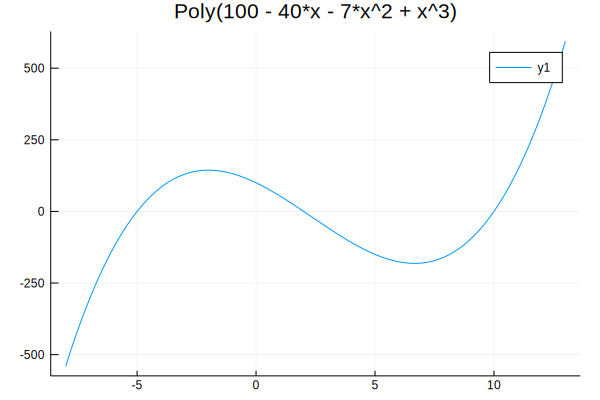

In [4]:
include("helpers.jl")

plot(p)

We can evaluate the polynomial at any point along the x axis:

In [5]:
p(1)

54

As you'd expect the polynomial evaluates to zero at the roots:

In [6]:
p(2)

0

From the representation of the polynomial type we can see that the coefficients are stored rather than the roots. We will need to access the coefficient values directly:

In [7]:
coeffs(p)

4-element Array{Int64,1}:
 100
 -40
  -7
   1

Now that we've gotten the coefficients from our polynomials we can encrypt them using the Paillier.jl package.

In [8]:
using Paillier

First we'll need to generate a public/private keypair.

In [11]:
pub, priv = generate_paillier_keypair(512)

(PublicKey(bits=512, hash=14535532748989303714), PrivateKey(hash=691691458823671736))

## References

- [1] Freedman M.J., Nissim K., Pinkas B. (2004) Efficient Private Matching and Set Intersection. In: Cachin C., Camenisch J.L. (eds) Advances in Cryptology - EUROCRYPT 2004. EUROCRYPT 2004. Lecture Notes in Computer Science, vol 3027. Springer, Berlin, Heidelberg [[pdf](https://link.springer.com/content/pdf/10.1007/978-3-540-24676-3_1.pdf)]
